# Zoekmachines

# Links

Slides: https://docs.google.com/presentation/d/1BoXR0ETlavRjB-x0CaPQclK0vwCbmQNFCaF1v4al9Qs/edit?usp=sharing

GitHub: https://github.com/RutgervanWoerkom/AssignmentWeek4

Dataset used: https://www.kaggle.com/snapcrack/all-the-news

# Table of content
Requirements: 

1. SERP can be found after running cells 7.1 and 7.2 and filling in all prompted parameters
2. Advanced search options are implemented in cell 6, options are tweakable when running cell 7.2
3. (B) Wordcloud is implemented in cell 4 and is automatically displayed for each document after running cell 7.2
4. A function that plots the timeline in which is indicated how many hits there are over time is implemented in cell 5, which are (again) displayed after running cell 7.2
5. A facet UI is implemented in our elasticsearch algorithm in cell 6. Faceted search is optional for the user and the user is prompted for enabling it when running cell 7.2
6. Our search results are evaluated in the latex report

## Notebook made by

__Name__: Midas Amersfoort, Rutger van Woerkom, Mats Gonggrijp

__Student id__ : 11857412, 11297654, 11220600


In [34]:
import sys
import json
from elasticsearch import Elasticsearch, helpers
import numpy as np
import os
import datetime
import math
import pandas as pd
from wordcloud import WordCloud
from nltk.corpus import stopwords
from IPython.display import clear_output
from collections import Counter
import matplotlib.pyplot as plt

# 1 Set up connection

In [35]:
HOST = 'http://localhost:9200/'
es = Elasticsearch(hosts=[HOST])
es_client = Elasticsearch(http_compress=True)

try:
    ! curl -XDELETE localhost:9200/*
except:
    None

{"acknowledged":true}

# 2 Create a doc generator

## 2.1 Setup filterkeys

In [36]:
def filterKeys(document):
    return {key: document[key] for key in use_these_keys}

## 2.2 Setup format for elasticsearch database

In [37]:
def doc_generator(df, folder_name):
    df_iter = df.iterrows()
    
    for index, document in df_iter:
 
        if '/' in document['date']:
            document['date'] = document['date'].replace('/','-')
            document['date'] = datetime.datetime.strptime(document['date'],'%Y-%m-%d').date()


        yield {
                "_index": folder_name,
                "_type": "_doc",
                "_id" : f"{index}",
                "_source": filterKeys(document),
            }

# 3 Load and bulk csv's

In [38]:
def bulking(dataset_path):
    
    def _load_csvs(dataset_path,folder,filename):
        dfs = pd.DataFrame()
        dfs['index'] = dfs.index
        dfs = dfs.set_index('index')

        df = pd.read_csv(dataset_path + '/' + folder + '/' + filename) 
        df['index'] = df.index
        df = df.set_index('index')
        df = df.dropna(axis=0)
        dfs = pd.concat([dfs,df],ignore_index=True, sort=True)

        return dfs.fillna(0), filename
    
    global facet_categories
    global use_these_keys
    facet_categories = []
    use_these_keys = []
    
    # read and join the two data files
    for folder in os.listdir(dataset_path):
        for file in os.listdir(dataset_path + '/' + folder):

            if file.endswith(".csv"):
                df, filename = _load_csvs(dataset_path,folder,file)
                use_these_keys = [col for col in df if not col == "Unnamed: 0"]
                facet_categories.extend(use_these_keys)

                helpers.bulk(es_client, doc_generator(df,filename))

# 4 Create wordclouds

In [39]:
def wordcloud(text):
    cachedStopWords = stopwords.words("english")
    text = ' '.join([word for word in text.split() if word.lower() not in cachedStopWords])

    wordcloud = WordCloud().generate(text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# 5 Plot timeline

In [40]:
def plot_timeline(results):
    timeline = []
    for res in results:
        timeline.append(res['_source']['date'][:7])
    timeline.sort()
    dates = list(Counter(timeline).values())
    plt.bar(list(Counter(timeline).keys()), dates)
    plt.xticks(rotation=90)
    plt.title('Monthly Timeline')
    plt.xlabel('Month')
    plt.ylabel('N/o results')
    plt.show()

# 6 Create interactive UI for elasticsearch algorithm

In [41]:
def prompt_search(number_of_results):
    print("Do you want to use Facet? (y/n)")
    fields = []
    
    facet_cats = list(set([cat for cat in facet_categories 
                           if not (cat == 'id' or cat == 'date' or cat == 'month' or cat == 'year')]))
    
    facet = ""
    while True:
        facet = input()
        if facet == str('y'):

            print("Enter a indices of categories you wish to use (e.g.: '1,4,8')")
            for i, cat in enumerate(facet_cats):
                print(i,cat)
                
            while True:           
                cats = np.array([int(index) for index in str(input()).split(',')])
                
                if all([0 <=  i and i < len(facet_cats) for i in cats]):
                    fields = [facet_cats[int(i)] for i in cats]
                    break
                    
                else:
                    print("Please enter a valid index")
                           
            break
                    
            
        elif facet == str('n'):
            break

        else:
            print("\nPlease enter 'y' or 'n'.")
    
    
    while True:
        print("Enter your search request: ")
        search_request = input()
        clear_output()


        query={
          "query": {
              "multi_match": {
                  "query": search_request,
                  "fields": fields
              }
          }
        }
        results = es_client.search(body=query, size=number_of_results)['hits']['hits']

        if results:
            break
        else:
            clear_output()
            print("Unfortunately we couldn't find what you are looking for..")
        
    
    plot_timeline(results)
    
    print()
    
    while True:
    
        print("Enter the index of the document you wish to open: ")
        for i, doc in enumerate(results):
            doc_info = doc['_source']
            print("""
            index = {}
            author: {}
            content: 
            "{}"
            date: {}
            """.format(i, 
                       doc_info['author'],
                       doc_info['content'][:300]+'...',
                       doc_info['date']))

            wordcloud(doc_info['content'])
        ans = ''
        while True:
            print("Enter the index of the document you wish to open: ")
            result_index = int(input())
            if 0 <= result_index and result_index < len(results):
                clear_output()
                print(results[result_index]['_source']['title'] + '\nby: ' + results[result_index]['_source']['author'])
                wordcloud(results[result_index]['_source']['content'])
                print(results[result_index]['_source']['content'])
                while True:
                    print("\nSelect another document? (y/n)")
                    ans = input()
                    if ans == 'y' or ans == 'n':
                        break
                    else:
                        print("\nPlease enter 'y' or 'n'.")
                break
                        
        if ans == 'y':
            clear_output()
            continue
        elif ans == 'n':
            clear_output()
            print("Thank you for using our search engine! :)")
            break

# 7 Set parameters to run the search algorithm (optional user input)

## 7.1 Run bulking algorithm

##### To run, create a folder called "datasets" in the same folder as this notebook, in which folders containing csv files can be placed.

In [42]:
""" Usage of the bulking function:
Input:
- set path to folder that contains datasets (nested in other folders!)
Output:
- the bulking algorithm constructs the elasticsearch database
"""
dataset_path = "datasets"
bulking(dataset_path)

## 7.2 Run search algorithm

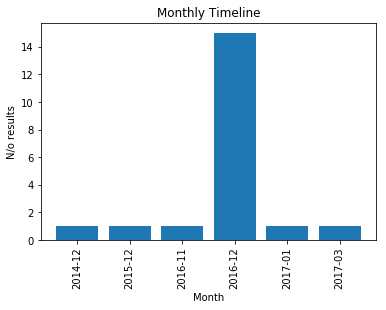


Enter the index of the document you wish to open: 

            index = 0
            author: Todd VanDerWerff
            content: 
            " It’s late December, which means it’s time for TV networks to haul out holiday standards. But what if you’re not in the mood for the kinds of holiday cheer whipped up by A Christmas Story or It’s a Wonderful Life? What if you want to celebrate the season with something a little less filled with chee..."
            date: 2014-12-08
            


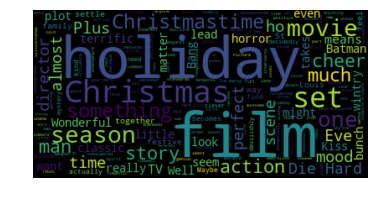


            index = 1
            author: Garrison Keillor
            content: 
            "   Garrison Keillor is an author and radio personality.       It is hard to believe that the Creator of our universe with its billions of galaxies could have sent Himself to this little blue blip not so long ago in the form of an infant born to a virgin, to be first worshiped by illiterate shepherds..."
            date: 2016-12-20
            


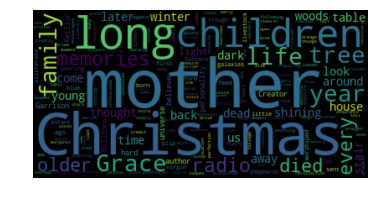


            index = 2
            author: George Weigel
            content: 
            "Whether it’s celebrated according to the Gregorian or the Julian calendar, Christmastide in Ukraine this season might seem to be one in which the bad news is all the news there is. Russian aggression,   but lethal, continues in the eastern regions of the country, as do   and other forms of Russian a..."
            date: 2016-12-29
            


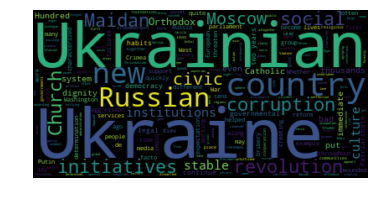


            index = 3
            author: Julie Zauzmer
            content: 
            "     Donald Trump’s path to electoral victory was paved in part with a promise that Santa Claus might make: “We’re all going to be saying ‘merry Christmas’ again. ” Months before he stood on a stage in Orlando as   last week  —   in front of 16 Christmas trees on a podium with a sign that said “Merr..."
            date: 2016-12-23
            


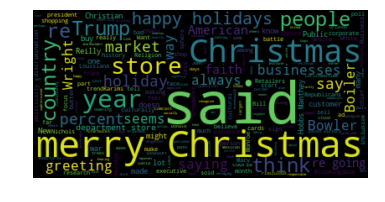


            index = 4
            author: Alissa Wilkinson
            content: 
            " Every weekend, we pick a movie you can stream that dovetails with current events. Old, new, blockbuster, arthouse: They’re all fair game. What you can count on is a weekend watch that sheds new light on the week that was. The movie of the week for December 18 through 24 is A Christmas Tale (2008) w..."
            date: 2016-12-24
            


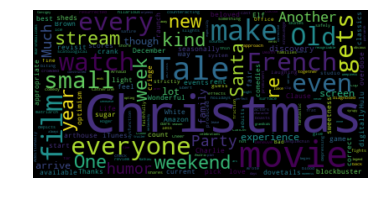


            index = 5
            author: Steven W Thrasher
            content: 
            "Christmas music is inescapable this time of year, making it impossible to hold a neutral opinion about the genre. But what causes people to fall into one camp or the other? Here, two writers flesh out the very personal reasons that the same annual din makes one desolate and the other merry. I hate C..."
            date: 2016-12-24
            


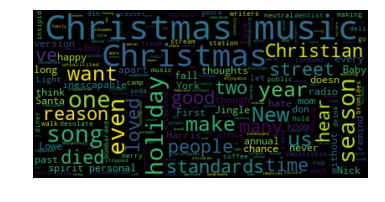


            index = 6
            author: NPR Staff
            content: 
            "Neil Diamond is celebrating 50 years in the music business, and he has a lot of fans to celebrate with him. In the past   he has sold more than 125 million records, released more than 40 albums, and put songs into the minds of millions. Now, Diamond is back with another album: Acoustic Christmas. Di..."
            date: 2016-12-17
            


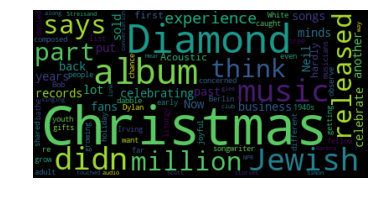


            index = 7
            author: Jordan Lorence
            content: 
            "  The New York Times recently published an article purporting to trace the history of the “War on Christmas. ”  The article concludes that “there is no evidence of an organized attack on Christmas in the United States,” and expressed skepticism about the “alleged liberal antagonism toward the holida..."
            date: 2016-12-22
            


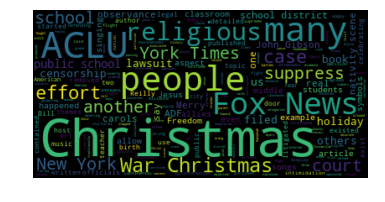


            index = 8
            author: Jason Samenow
            content: 
            "     Snow on Christmas creates the magical scenes that have inspired songs and stories. Even some people who detest snow are enamored by visions of a glistening white landscape on Christmas Day. So which fortunate locations in the Lower 48 will enjoy a white Christmas this year? Presently about 40 p..."
            date: 2016-12-21
            


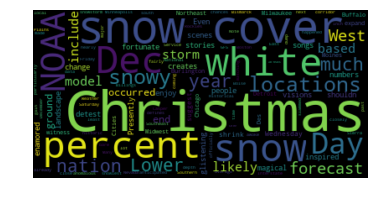


            index = 9
            author: Kathryn Jean Lopez
            content: 
            "‘Why do people go to church on Christmas?” It was one of the questions passersby asked as they noticed the security line before midnight Mass at St. Patrick’s Cathedral on Christmas Eve. There were some colorful things said, as well, as you might imagine after 10 p. m. on a Saturday night in the Big..."
            date: 2017-01-02
            


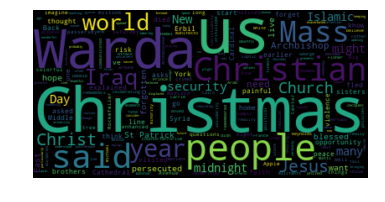


            index = 10
            author: Max Jaeger
            content: 
            "Can’t we just have coal instead? If you hadn’t heard enough of Mariah Carey’s    Christmas carol “All I want for Christmas is you,” strap in  —   it’s becoming an animated movie. The artist,   took to Twitter on Wednesday top promote the new pic. “A #Dream come true “All I Want For Christmas Is You”..."
            date: 2017-03-23
            


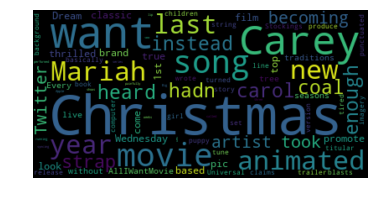


            index = 11
            author: Andrea Morabito
            content: 
            "Terry Crews is something of a Christmas  . The actor (“Brooklyn  ”) and married father of five has been, as he says, doing Christmas for generations  —   tracking down   toys from    to Teletubbies to video games to now shopping for his    granddaughter. So his new special “Terry Crews Saves Christm..."
            date: 2016-12-19
            


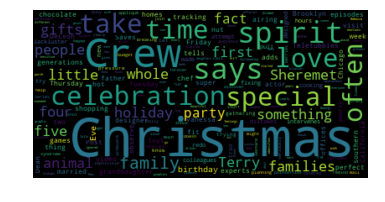


            index = 12
            author: Todd VanDerWerff
            content: 
            " Movies where a large family gathers to celebrate Christmas only have to nail one scene, and Almost Christmas does, more or less.        Rating  3     It’s the scene at Christmas dinner where everything comes to a head. You know the one: Every member of the family has their own little storyline, and..."
            date: 2016-11-12
            


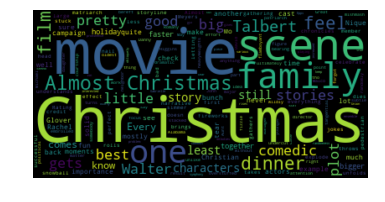


            index = 13
            author: E.J. Dionne Jr.
            content: 
            " Some things Donald Trump says enrage me, while others get under my skin. The pronouncement that does both is his regular claim that until he prevailed, Americans were not free to say “merry Christmas” to each other. He was at it again last week in West Allis, Wis. during his       Victory Tour. Tru..."
            date: 2016-12-21
            


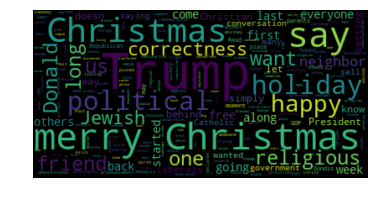


            index = 14
            author: Karly Domb Sadof
            content: 
            "        People line up at the parcel post window at the General Post Office to mail their Christmas packages, in New York on Dec. 22, 1927. (Underwood   Images)  According to Sue Brennan of the U. S. Postal service, USPS estimates that it will deliver more than 750 million packages between Thanksgiv..."
            date: 2016-12-23
            


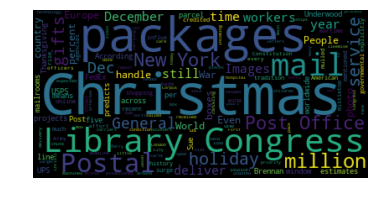


            index = 15
            author: Aja Romano
            content: 
            " 2016 has been a shitty year  —   a heartbreaking,   barely bearable year. You’ve made it this far, and now it might be tempting, as you search for the perfect holiday film with which to round out the year, to kick back and let Bruce Willis carry you, barefoot, over crunching glass, amid the wailing..."
            date: 2016-12-22
            


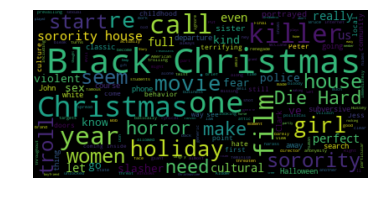


            index = 16
            author: Tanya Pai
            content: 
            " It might seem unbelievable given that the radio has been blasting Christmas tunes since Thanksgiving, but the true Christmas season actually starts on Christmas Day itself. That’s right: December 25 marks the official start of the 12 days of Christmas, the Christian tradition that shares its name w..."
            date: 2015-12-25
            


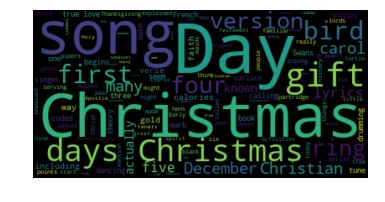


            index = 17
            author: Camila Domonoske
            content: 
            "Montreal wanted a nice Christmas tree. A nice, tall Christmas tree. Something people would be proud to compare to the behemoth at Rockefeller Center in New York City. What they got is more than 85 feet tall, so it’s got that going for it, which is nice. But otherwise . .. well, it’s been described a..."
            date: 2016-12-20
            


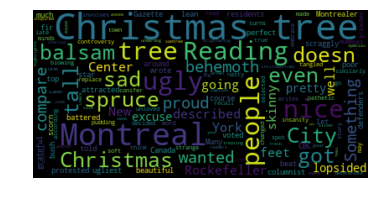


            index = 18
            author: Todd VanDerWerff
            content: 
            " Few fictional characters have been portrayed onscreen as often as Ebenezer Scrooge, the hero and villain of Charles Dickens’s A Christmas Carol.    Really, the list comes down to Scrooge, Dracula, and Sherlock Holmes, all British literary characters who’ve been warped and twisted in all directions ..."
            date: 2016-12-21
            


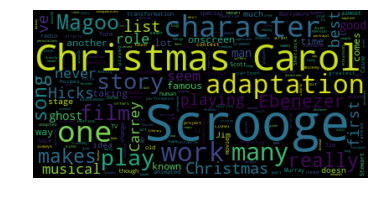


            index = 19
            author: Stuart Heritage
            content: 
            "1. Don’t take pictures of your presents. Christmas is a minefield of potentially botched etiquette, and social media only makes it worse. And, clearly, the crime one can commit is making a fuss online about all the stuff you have been given. Look, we get it. You got a lot of presents this year. What..."
            date: 2016-12-24
            


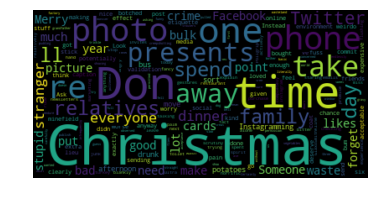

Enter the index of the document you wish to open: 


In [ ]:
""" Usage of the prompt_search algorithm:
Input:
- number_of_results: an integer that determines the max number of results that will be displayed to user
Output:
- a series of optional user inputs that lead to a search result output
"""
number_of_results = 20
prompt_search(number_of_results)